In [2]:
import pandas as pd

users = pd.read_csv("../data/users.csv", parse_dates=["signup_ts"])
events = pd.read_csv("../data/events.csv", parse_dates=["event_ts"])
subs = pd.read_csv("../data/subscriptions.csv", 
                   parse_dates=["subscription_start_ts", "churn_ts"])

print(users.shape)
print(events.shape)
print(subs.shape)

(20000, 8)
(229806, 8)
(3654, 6)


In [3]:
print("Unique users in events:", events["user_id"].nunique())
print("Unique users in subs:", subs["user_id"].nunique())

print("Total users:", len(users))
print("Paid conversion:", len(subs) / len(users))

Unique users in events: 20000
Unique users in subs: 3654
Total users: 20000
Paid conversion: 0.1827


In [4]:
events_per_user = events.groupby("user_id").size()

print(events_per_user.describe())

count    20000.000000
mean        11.490300
std          5.408222
min          2.000000
25%          7.000000
50%         11.000000
75%         15.000000
max         31.000000
dtype: float64


In [5]:
funnel_steps = [
    "signup",
    "onboarding_start",
    "create_first_project",
    "trial_start",
    "subscription_created"
]

funnel_counts = {}

for step in funnel_steps:
    funnel_counts[step] = events[events["event_name"] == step]["user_id"].nunique()

funnel_df = pd.DataFrame.from_dict(
    funnel_counts, orient="index", columns=["users"]
)

funnel_df["conversion_from_previous"] = funnel_df["users"] / funnel_df["users"].shift(1)
funnel_df

,users,conversion_from_previous
signup,20000,NaN
onboarding_start,16827,0.841350
create_first_project,11876,0.705770
trial_start,10020,0.843718
subscription_created,3654,0.364671


In [6]:
activated_users = (
    events[events["event_name"] == "create_first_project"]
    ["user_id"]
    .unique()
)

users["is_activated"] = users["user_id"].isin(activated_users)

users["is_activated"].mean()

np.float64(0.5938)

In [7]:
paid_users = subs["user_id"].unique()

users["is_paid"] = users["user_id"].isin(paid_users)

users["is_paid"].mean()

np.float64(0.1827)

In [8]:
conversion_by_activation = (
    users.groupby("is_activated")["is_paid"]
    .mean()
    .reset_index()
)

conversion_by_activation

,is_activated,is_paid
0,False,0.007016
1,True,0.302880


In [9]:
activated_conv = conversion_by_activation.loc[
    conversion_by_activation["is_activated"] == True,
    "is_paid"
].values[0]

non_activated_conv = conversion_by_activation.loc[
    conversion_by_activation["is_activated"] == False,
    "is_paid"
].values[0]

uplift = activated_conv / non_activated_conv

print("Activated conversion rate:", activated_conv)
print("Non-activated conversion rate:", non_activated_conv)
print("Conversion uplift (x):", round(uplift, 2))

Activated conversion rate: 0.3028797574941058
Non-activated conversion rate: 0.007016248153618907
Conversion uplift (x): 43.17


In [10]:
current_activation_rate = users["is_activated"].mean()
total_users = len(users)

improvement = 0.05  # 5 percentage points

new_activation_rate = current_activation_rate + improvement

additional_activated_users = (new_activation_rate - current_activation_rate) * total_users

expected_new_paid_users = additional_activated_users * activated_conv

average_mrr = subs["mrr"].mean()

additional_monthly_revenue = expected_new_paid_users * average_mrr

print("Additional Paid Users:", round(expected_new_paid_users))
print("Estimated Monthly MRR Gain: $", round(additional_monthly_revenue))
print("Estimated Annual ARR Gain: $", round(additional_monthly_revenue * 12))

Additional Paid Users: 303
Estimated Monthly MRR Gain: $ 24677
Estimated Annual ARR Gain: $ 296122


Activated users convert at 30.3% compared to just 0.7% for non-activated users — a 43x uplift.
Increasing activation by 5 percentage points would drive an estimated $296K in additional ARR.


In [11]:
activation_by_channel = (
    users.groupby("acquisition_channel")["is_activated"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

activation_by_channel

,acquisition_channel,is_activated
0,referral,0.750382
1,organic,0.686749
2,paid_search,0.590898
3,partner,0.575459
4,paid_social,0.433869


Referral users activate at 75% while Paid Social users activate at only 43%. Given that activation increases paid conversion by 43x, improving Paid Social onboarding presents a significant revenue opportunity.


In [12]:
paid_social_users = users[users["acquisition_channel"] == "paid_social"]

current_activation_ps = paid_social_users["is_activated"].mean()
organic_activation = activation_by_channel.loc[
    activation_by_channel["acquisition_channel"] == "organic",
    "is_activated"
].values[0]

activation_gap = organic_activation - current_activation_ps

additional_activated_ps = activation_gap * len(paid_social_users)

expected_new_paid_ps = additional_activated_ps * activated_conv

additional_mrr_ps = expected_new_paid_ps * average_mrr

print("Activation Gap:", round(activation_gap, 3))
print("Additional Paid Users:", round(expected_new_paid_ps))
print("Estimated Annual ARR Gain: $", round(additional_mrr_ps * 12))

Activation Gap: 0.253
Additional Paid Users: 386
Estimated Annual ARR Gain: $ 377637


In [13]:
# Identify trial users
trial_users = events[events["event_name"] == "trial_start"]["user_id"].unique()
users["started_trial"] = users["user_id"].isin(trial_users)

# Merge subscription info
users["is_paid"] = users["user_id"].isin(subs["user_id"])

trial_data = users[users["started_trial"] == True]

trial_to_paid_by_device = (
    trial_data.groupby("device")["is_paid"]
    .mean()
    .reset_index()
)

trial_to_paid_by_device

,device,is_paid
0,mobile,0.324193
1,web,0.381006


In [14]:
payment_failures = events[events["event_name"] == "payment_failed"]

failure_by_device = (
    payment_failures.merge(users[["user_id", "device"]], on="user_id")
    .groupby("device")
    .size()
)

failure_by_device

device
mobile    400
web       396
dtype: int64

In [15]:
# Count checkout attempts by device
checkout_events = events[events["event_name"] == "checkout_start"]

checkout_by_device = (
    checkout_events
    .merge(users[["user_id", "device"]], on="user_id")
    .groupby("device")
    .size()
)

failure_by_device = (
    payment_failures
    .merge(users[["user_id", "device"]], on="user_id")
    .groupby("device")
    .size()
)

failure_rate = (failure_by_device / checkout_by_device).reset_index()
failure_rate.columns = ["device", "failure_rate"]

failure_rate

,device,failure_rate
0,mobile,0.137127
1,web,0.055130


In [16]:
# Calculate mobile checkout volume
mobile_checkout = checkout_by_device["mobile"]
mobile_failure_rate = failure_rate.loc[
    failure_rate["device"] == "mobile", "failure_rate"
].values[0]

web_failure_rate = failure_rate.loc[
    failure_rate["device"] == "web", "failure_rate"
].values[0]

failure_gap = mobile_failure_rate - web_failure_rate

# Potential recovered checkouts
recovered_checkouts = mobile_checkout * failure_gap

# Convert recovered checkouts to paid (use web trial-to-paid as benchmark)
web_trial_to_paid = trial_to_paid_by_device.loc[
    trial_to_paid_by_device["device"] == "web", "is_paid"
].values[0]

additional_paid_mobile = recovered_checkouts * web_trial_to_paid

additional_mrr_mobile = additional_paid_mobile * average_mrr

print("Failure Rate Gap:", round(failure_gap, 3))
print("Recovered Paid Users:", round(additional_paid_mobile))
print("Estimated Annual ARR Gain: $", round(additional_mrr_mobile * 12))

Failure Rate Gap: 0.082
Recovered Paid Users: 91
Estimated Annual ARR Gain: $ 89098


In [ ]:
activation_by_device = (
    users.groupby("device")["is_activated"]
    .mean()
    .reset_index()
)

activation_by_device

,device,is_activated
0,mobile,0.562552
1,web,0.607253


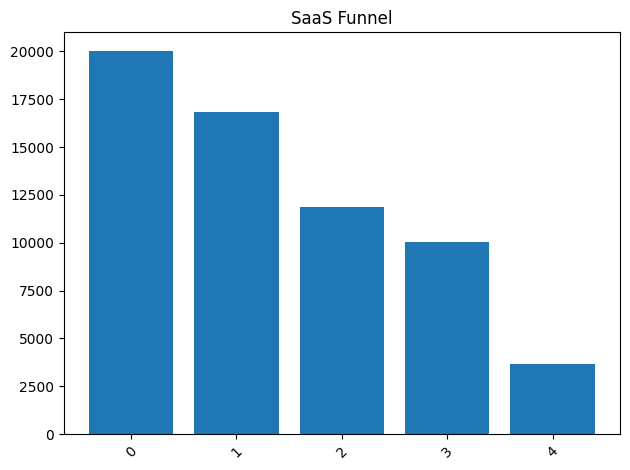

In [28]:
import os
os.makedirs("../reports/charts", exist_ok=True)

import matplotlib.pyplot as plt


plt.figure()
plt.bar(funnel_df.index, funnel_df["users"])
plt.title("SaaS Funnel")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../reports/charts/funnel.png", dpi=200)
plt.show()

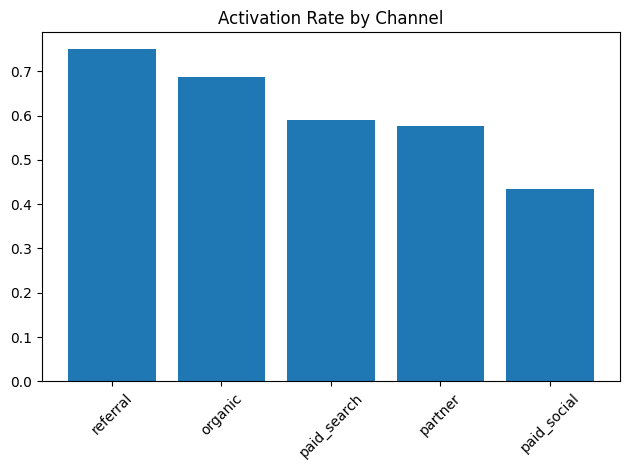

In [25]:
plt.figure()
plt.bar(activation_by_channel["acquisition_channel"],
        activation_by_channel["is_activated"])
plt.title("Activation Rate by Channel")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../reports/charts/activation_by_channel.png")
plt.show()

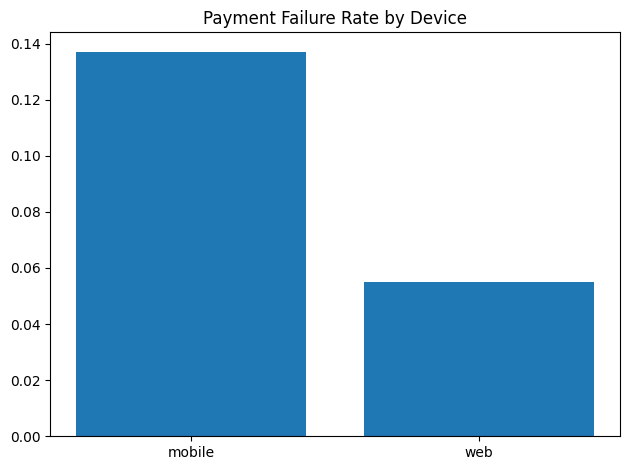

In [29]:
plt.figure()
plt.bar(failure_rate["device"], failure_rate["failure_rate"])
plt.title("Payment Failure Rate by Device")
plt.tight_layout()
plt.savefig("../reports/charts/payment_failure_by_device.png")
plt.show()